# Visualization of the Pb boundary conditions based on transects

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,778,798) # Northern Canada Basin 
bdy_WCB = (2168,2178,390,797) # Western Canada Basin 
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,293,303) # Hudson Bay

In [3]:
# Colors
land_color = '#a9a7a2'
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'
light_gray = '#b1b1b1'
light_land = '#d0d0cf'
land_edge  = '#929291'

#### Files

In [4]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [5]:
mesh        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept  = mesh['hdept'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
mesh_e3tps  = mesh['e3t_ps'].values[0,:,:]
mesh_e3t    = mesh['e3t_0'].values[0,:,:]
e3t_masked = np.ma.masked_where((mesh_bathy< 0.1), mesh_e3t)

In [6]:
hdepw   = mesh['hdepw'].values[0,:,:]
gdepw1d = mesh['gdepw_1d'].values[0,:]
gdept1d = mesh['gdept_1d'].values[0,:]

Boundary Condition file:

In [7]:
# BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_y2002m01.nc','r')
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2015m09.nc','r')
dPb_S  = np.array(BC.variables['dPb_S']).reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2])
dPb_N  = np.array(BC.variables['dPb_N']).reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2])
dPb_E  = np.array(BC.variables['dPb_E']).reshape(50,rimwidthE,bdy_NCB[1]-bdy_NCB[0])
dPb_W  = np.array(BC.variables['dPb_W']).reshape(50,rimwidthW,bdy_HB[1]-bdy_HB[0])

# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 

# Western Canada Basin
dPb_N_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 

BC.close()

#### Functions

In [8]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [9]:
def plot_transect(ax, variable, vrange=(30,35), label='', cmap=cmocean.cm.deep, labelling=True):
    
    ax.invert_yaxis()
    ax.set_ylim(4000, -60)
    ax.set_xlim(0, 1100)
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    # plot model boundary condition:
    bdy_cell = 0
    xx, zz = np.meshgrid(S_distance, depths)
    CB1 = ax.pcolormesh(xx, zz, variable[:,bdy_cell,:], vmin=vrange[0], vmax=vrange[1], cmap=cmap)
    ax.pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

    if labelling:
        ax.set_xlabel('Distance [km]', fontsize=7)
        ax.set_ylabel('Depth [m]', fontsize=7)

        axins = inset_axes(ax, width="5%", height="45%", loc='lower left', borderpad=1)

        CBar   = plt.colorbar(CB1, ax=ax, cax=axins); 
        CBar.set_label(f'{label}', fontsize=7)
        CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return CB1

In [18]:
def get_boundary_depths(bdy_distance, bdy_ind, cell=0):
    
    model_depths    = np.zeros((len(depths), len(bdy_distance)))
    model_distances = np.zeros((len(depths), len(bdy_distance)))

    for n in range(0,len(bdy_distance)): #bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]
        mesh_depth_adjusted = np.copy(gdepw1d)
        if (bdy_ind[1]-bdy_ind[0]) < (bdy_ind[3]-bdy_ind[2]): # depending on orientation of boundary
            bathy_ind           = mesh_mbathy[bdy_ind[0]+cell, bdy_ind[2]+n]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+cell, bdy_ind[2]+n]
        else:
            bathy_ind           = mesh_mbathy[bdy_ind[0]+n, bdy_ind[2]+cell]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+n, bdy_ind[2]+cell]

        model_depths[:,n]    = mesh_depth_adjusted
        model_distances[:,n] = bdy_distance[n]
    
    return model_depths, model_distances

#### Calculations

In [15]:
bdy_cell=5

In [19]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[bdy_cell,:]  , dPb_S_lons[bdy_cell,:])    # Labrador Sea
N_distance  = calc_distance(dPb_N_lats[bdy_cell-1,:], dPb_N_lons[bdy_cell-1,:])    # western CB
E_distance  = calc_distance(dPb_E_lats[:,bdy_cell-1], dPb_E_lons[:,bdy_cell-1]) # northern CB
W_distance  = calc_distance(dPb_W_lats[:,bdy_cell], dPb_W_lons[:,bdy_cell]) # Hudson Bay

In [20]:
S_model_depths, S_model_distances = get_boundary_depths(S_distance, bdy_LS,  cell=bdy_cell)
N_model_depths, N_model_distances = get_boundary_depths(N_distance, bdy_WCB, cell=bdy_cell-1)
E_model_depths, E_model_distances = get_boundary_depths(E_distance, bdy_NCB, cell=bdy_cell-1)
W_model_depths, W_model_distances = get_boundary_depths(W_distance, bdy_HB,  cell=bdy_cell)

#### Figures

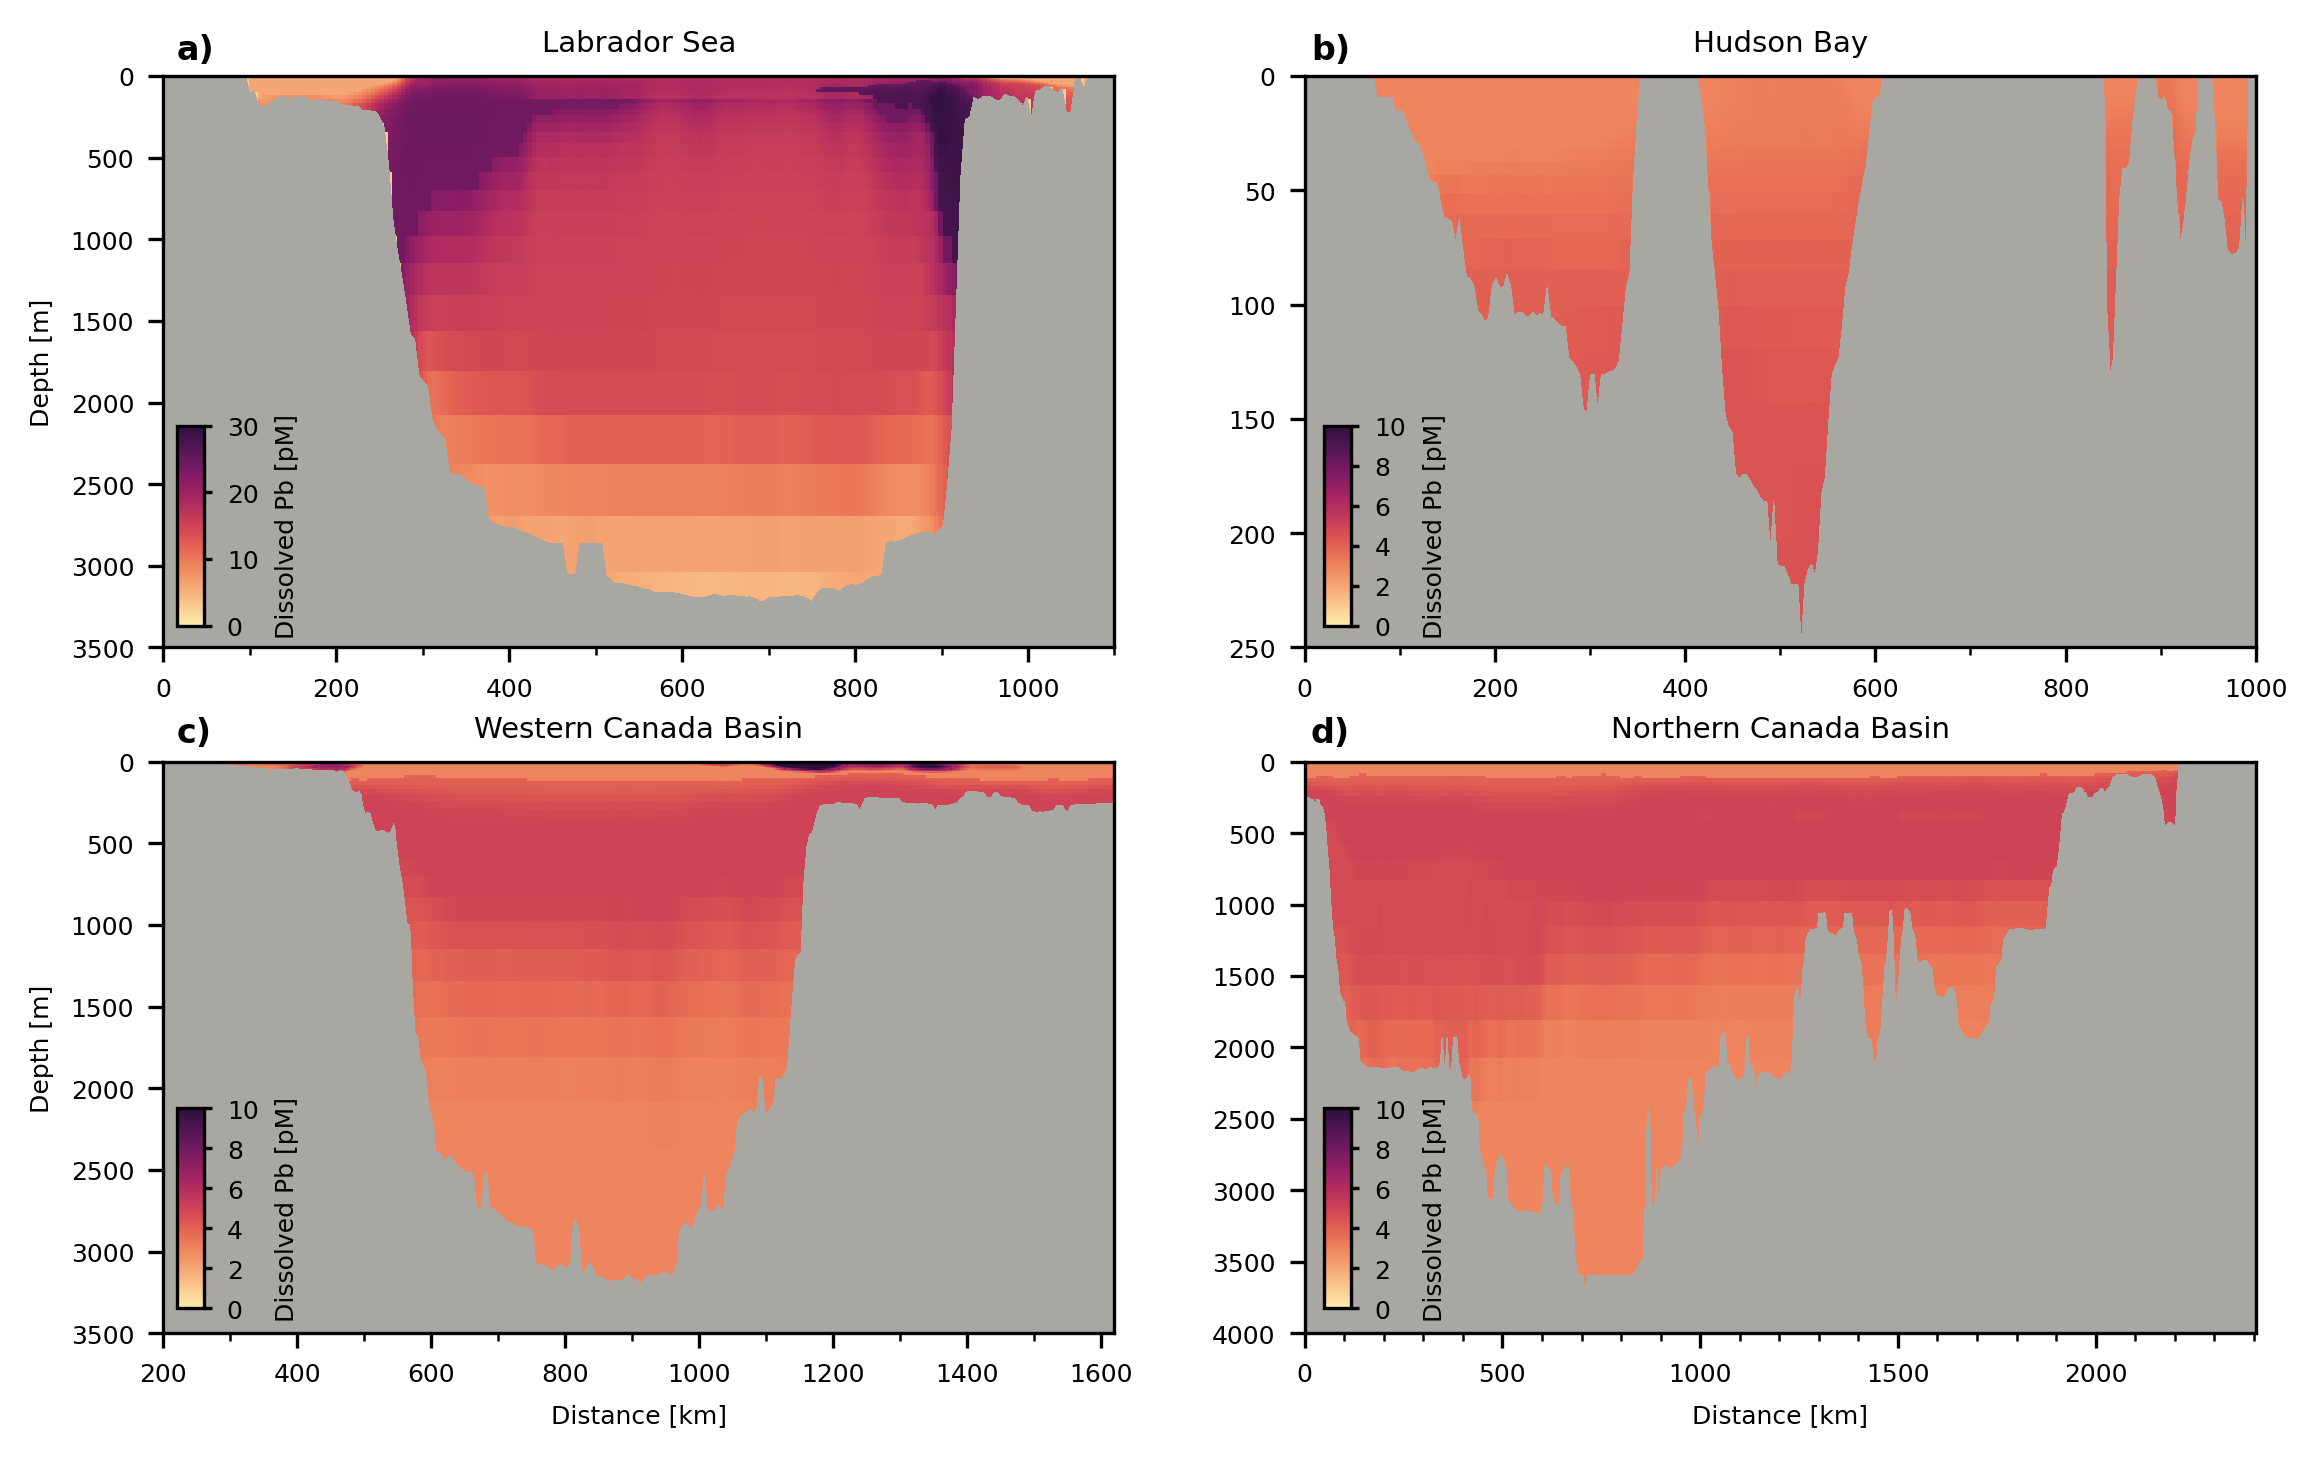

In [43]:
fig, ax = plt.subplots(2,2, figsize=(4.5*2, 3.7*1.5), dpi=300)

ax[0,0].set_title('Labrador Sea', fontsize=7)
ax[0,1].set_title('Hudson Bay', fontsize=7)
ax[1,0].set_title('Western Canada Basin', fontsize=7)
ax[1,1].set_title('Northern Canada Basin', fontsize=7)

ax[1,0].set_xlabel('Distance [km]', fontsize=6)
ax[1,1].set_xlabel('Distance [km]', fontsize=6)
ax[0,0].set_ylabel('Depth [m]', fontsize=6)
ax[1,0].set_ylabel('Depth [m]', fontsize=6)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.xaxis.set_minor_locator(MultipleLocator(100))

ax[0,0].set_xlim(0,1100)    
ax[0,0].set_ylim(3500,0)
ax[0,1].set_ylim(250,0)
ax[1,0].set_ylim(3500,0)
ax[1,1].set_ylim(4000,0)
ax[0,1].set_xlim(0,1000)
ax[1,0].set_xlim(200,1620)
    
cmap = cmocean.cm.matter

# Labrador Sea:
xx, zz = np.meshgrid(S_distance, gdepw1d)
CB1 = ax[0,0].pcolormesh(xx, zz, dPb_S[:,bdy_cell,:]*1e12, vmin=0, vmax=30, cmap=cmap)
# ax[0,0].plot(S_distance, hdepw[bdy_LS[0]+bdy_cell,bdy_LS[2]:bdy_LS[3]], '-w', zorder=3)
# ax[0,0].plot(S_distance, mesh_hdept[bdy_LS[0]+bdy_cell,bdy_LS[2]:bdy_LS[3]], '-r', zorder=3)
ax[0,0].pcolormesh(xx, S_model_depths, dPb_S[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)

# Hudson Bay: 
xx, zz = np.meshgrid(W_distance, gdepw1d)
CB2 = ax[0,1].pcolormesh(xx, zz, dPb_W[:,bdy_cell,:]*1e12, vmin=0, vmax=10, cmap=cmap)
ax[0,1].pcolormesh(xx, W_model_depths, dPb_W[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)
# ax[0,1].pcolormesh(xx, zz, dPb_W_mdepths[:,:,bdy_cell], cmap=matplotlib.colors.ListedColormap([land_color]))

# Western Canada Basin:
xx, zz = np.meshgrid(N_distance, gdepw1d)
CB3 = ax[1,0].pcolormesh(xx, zz, dPb_N[:,bdy_cell,:]*1e12, vmin=0, vmax=10, cmap=cmap)
ax[1,0].pcolor(xx, N_model_depths, dPb_N[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)
# ax[1,0].pcolormesh(xx, zz, dPb_N_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# Northern Canada Basin:
xx, zz = np.meshgrid(E_distance[::-1], gdepw1d)
CB4 = ax[1,1].pcolormesh(xx, zz, dPb_E[:,-bdy_cell,:]*1e12, vmin=0, vmax=10, cmap=cmap)
ax[1,1].pcolor(xx, E_model_depths, dPb_E[:,-bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)
# ax[1,1].pcolormesh(xx, zz, dPb_E_mdepths[:,:,bdy_cell], cmap=matplotlib.colors.ListedColormap([land_color]))

# add text labels:
fig.text(0.13, 0.89, 'a)', fontsize=8, weight='bold');
fig.text(0.55, 0.89, 'b)', fontsize=8, weight='bold');
fig.text(0.13, 0.48, 'c)', fontsize=8, weight='bold');
fig.text(0.55, 0.48, 'd)', fontsize=8, weight='bold');

cbax1 = fig.add_axes([0.13 , 0.55, 0.01, 0.12]);
cbax2 = fig.add_axes([0.555, 0.55, 0.01, 0.12]);
cbax3 = fig.add_axes([0.13 , 0.14, 0.01, 0.12]);
cbax4 = fig.add_axes([0.555, 0.14, 0.01, 0.12]);
cbaxes = [cbax1, cbax2, cbax3, cbax4]

for n,cb in enumerate([CB1, CB2, CB3, CB4]):
    if n > 0:
        CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n], ticks=[0,2,4,6,8,10]); 
    else:
        CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n]); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=2, width=0.8, labelsize=6)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/M2-transect-boundary.jpg', dpi=300, bbox_inches='tight')

hdepw is the same as hdept+ 0.5*e3t_ps. So, hdepw takes into account the partial step, so does e3t.

In [130]:
[print(S_model_depths[20:25,i]) for i in range(20,26)]

[118.40114594 118.40114594 118.40114594 118.40114594 142.6778928 ]
[100.626091   100.626091   100.626091   119.71409305 142.6778928 ]
[178.68489075 178.68489075 178.68489075 178.68489075 178.68489075]
[197.90887451 197.90887451 197.90887451 197.90887451 197.90887451]
[198.9788208 198.9788208 198.9788208 198.9788208 198.9788208]
[161.72213745 161.72213745 161.72213745 161.72213745 161.72213745]


[None, None, None, None, None, None]

In [165]:
print(hdepw[bdy_LS[0]+5,bdy_LS[2]+20:bdy_LS[2]+26])
print(mesh_hdept[bdy_LS[0]+5,bdy_LS[2]+20:bdy_LS[2]+26] + (mesh_e3tps[bdy_LS[0]+5,bdy_LS[2]+20:bdy_LS[2]+26]/2))
print(np.ma.sum(e3t_masked[:,bdy_LS[0]+5,bdy_LS[2]+20:bdy_LS[2]+26], axis=0))

[118.401146 100.62609  178.68489  197.90887  198.97882  161.72214 ]
[117.97794867 100.24901048 178.48758653 197.25951535 198.30430506
 161.27105879]
[118.25544738769531 100.50579833984375 178.45594787597656
 197.6543426513672 198.72286987304688 161.51612854003906]


In [54]:
print([gdepw1d[i] for i in mesh_mbathy[bdy_LS[0]+5, bdy_LS[2]+20:bdy_LS[2]+26]])
print([gdept1d[i] for i in mesh_mbathy[bdy_LS[0]+5, bdy_LS[2]+20:bdy_LS[2]+26]])

[119.71409305217685, 100.6260918181888, 203.4735238222038, 203.4735238222038, 203.4735238222038, 170.29385650225936]
[130.66598417791965, 109.72928079679241, 222.47516907053705, 222.47516907053705, 222.47516907053705, 186.12556727677588]


In [53]:
print(mesh_e3tps[bdy_LS[0]+5,bdy_LS[2]+20:bdy_LS[2]+26])
print([mesh_e3t[i-1,bdy_LS[2]+5,bdy_LS[2]+20+n] for n, i in enumerate(mesh_mbathy[bdy_LS[0]+5, bdy_LS[2]+20:bdy_LS[2]+26])])

[17.74964429 15.84587558  8.37986666 27.57826531 28.64678762 19.01810025]
[19.060715, 15.845876, 33.13551, 33.13551, 33.13551, 27.578053]


Load multi-month boundaries:

In [13]:
dPb_S_monthly = np.empty((12,50,10,226))

for month in range(1,13):
#     BC     = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/Pb_OBC_y2002m{month:02}.nc','r')
    BC     = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/increase_ACW/Pb_OBC_y2002m{month:02}.nc','r')
    dPb_S_monthly[month-1,:,:,:] = np.array(BC.variables['dPb_S']).reshape(50,10,226)
    BC.close()

In [14]:
np.count_nonzero(dPb_S_monthly==0)

0

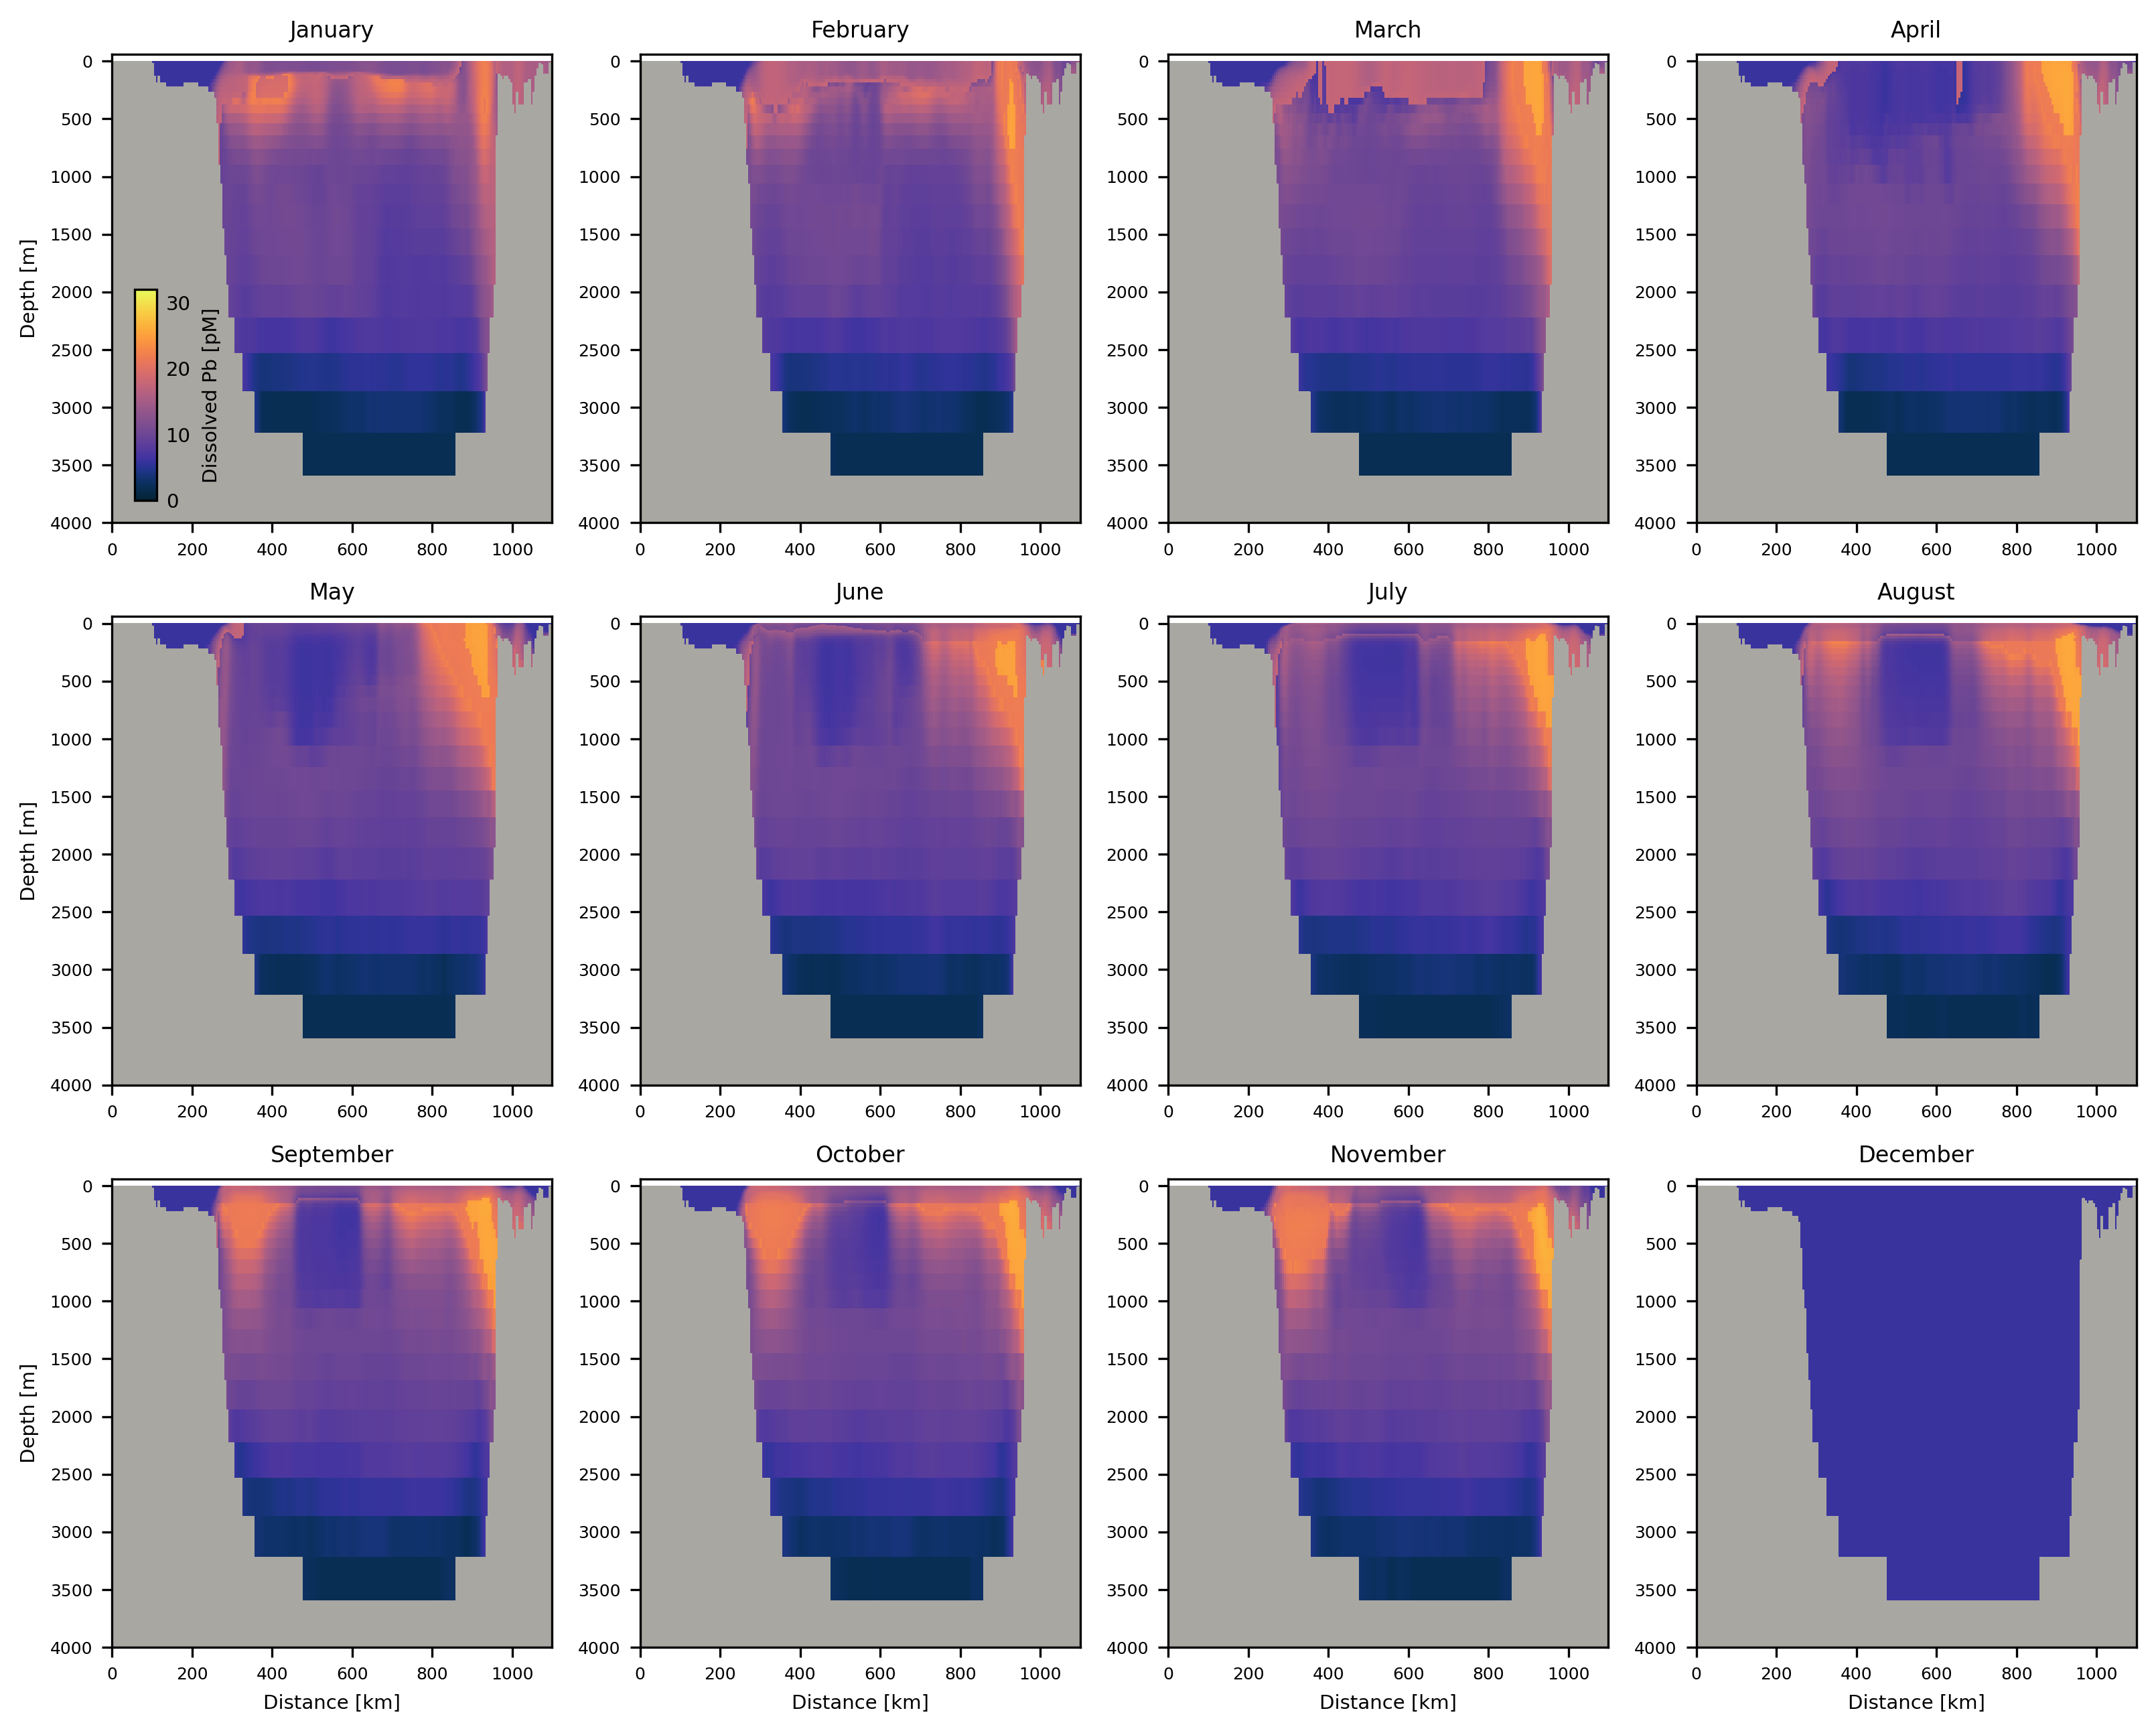

In [15]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=300)

axes = ax.ravel()
months=['January','February', 'March','April','May','June','July','August','September','October','November','December']

for month in range(0,12):
   
    CB1 = plot_transect(axes[month], dPb_S_monthly[month,:,:,:]*1e12, vrange=(0,32), label='', cmap=cmocean.cm.thermal, labelling=False)
        
    axes[month].set_title(f'{months[month]}', fontsize=8)
    
# labelling:
for axis in ax[:,0].ravel():
    axis.set_ylabel('Depth [m]', fontsize=7)
    
for axis in ax[2,:].ravel():
    axis.set_xlabel('Distance [km]', fontsize=7)

axins = inset_axes(ax[0,0], width="5%", height="45%", loc='lower left', borderpad=0.8)
CBar  = plt.colorbar(CB1, ax=ax[0,0], cax=axins); 
CBar.set_label(f'Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/LS_boundary_conditions_2002.jpg', dpi=300, bbox_inches='tight')

In [71]:
dPb_N_monthly = np.empty((12,50,rimwidthN,bdy_WCB[3]-bdy_WCB[2]))

for month in range(1,13):
    BC     = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2009m{month:02}.nc','r')
    dPb_N_monthly[month-1,:,:,:] = np.flip(np.array(BC.variables['dPb_N']).reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2]), axis=1)
    BC.close()

In [72]:
def plot_wCB_transect(ax, variable, vrange=(30,35), label='', cmap=cmocean.cm.deep, labelling=True):
    
    ax.invert_yaxis()
    ax.set_ylim(200, -10)
    ax.set_xlim(0, 1600)
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    # plot model boundary condition:
    bdy_cell = 0
    xx, zz = np.meshgrid(N_distance, depths)
    CB1 = ax.pcolormesh(xx, zz, variable[:,bdy_cell,:]*1e12, vmin=vrange[0], vmax=vrange[1], cmap=cmap)
    ax.pcolormesh(xx, zz, dPb_N_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))
    
    if labelling:
        ax.set_xlabel('Distance [km]', fontsize=7)
        ax.set_ylabel('Depth [m]', fontsize=7)

        axins = inset_axes(ax, width="5%", height="45%", loc='lower left', borderpad=1)

        CBar   = plt.colorbar(CB1, ax=ax, cax=axins); 
        CBar.set_label(f'{label}', fontsize=7)
        CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return CB1

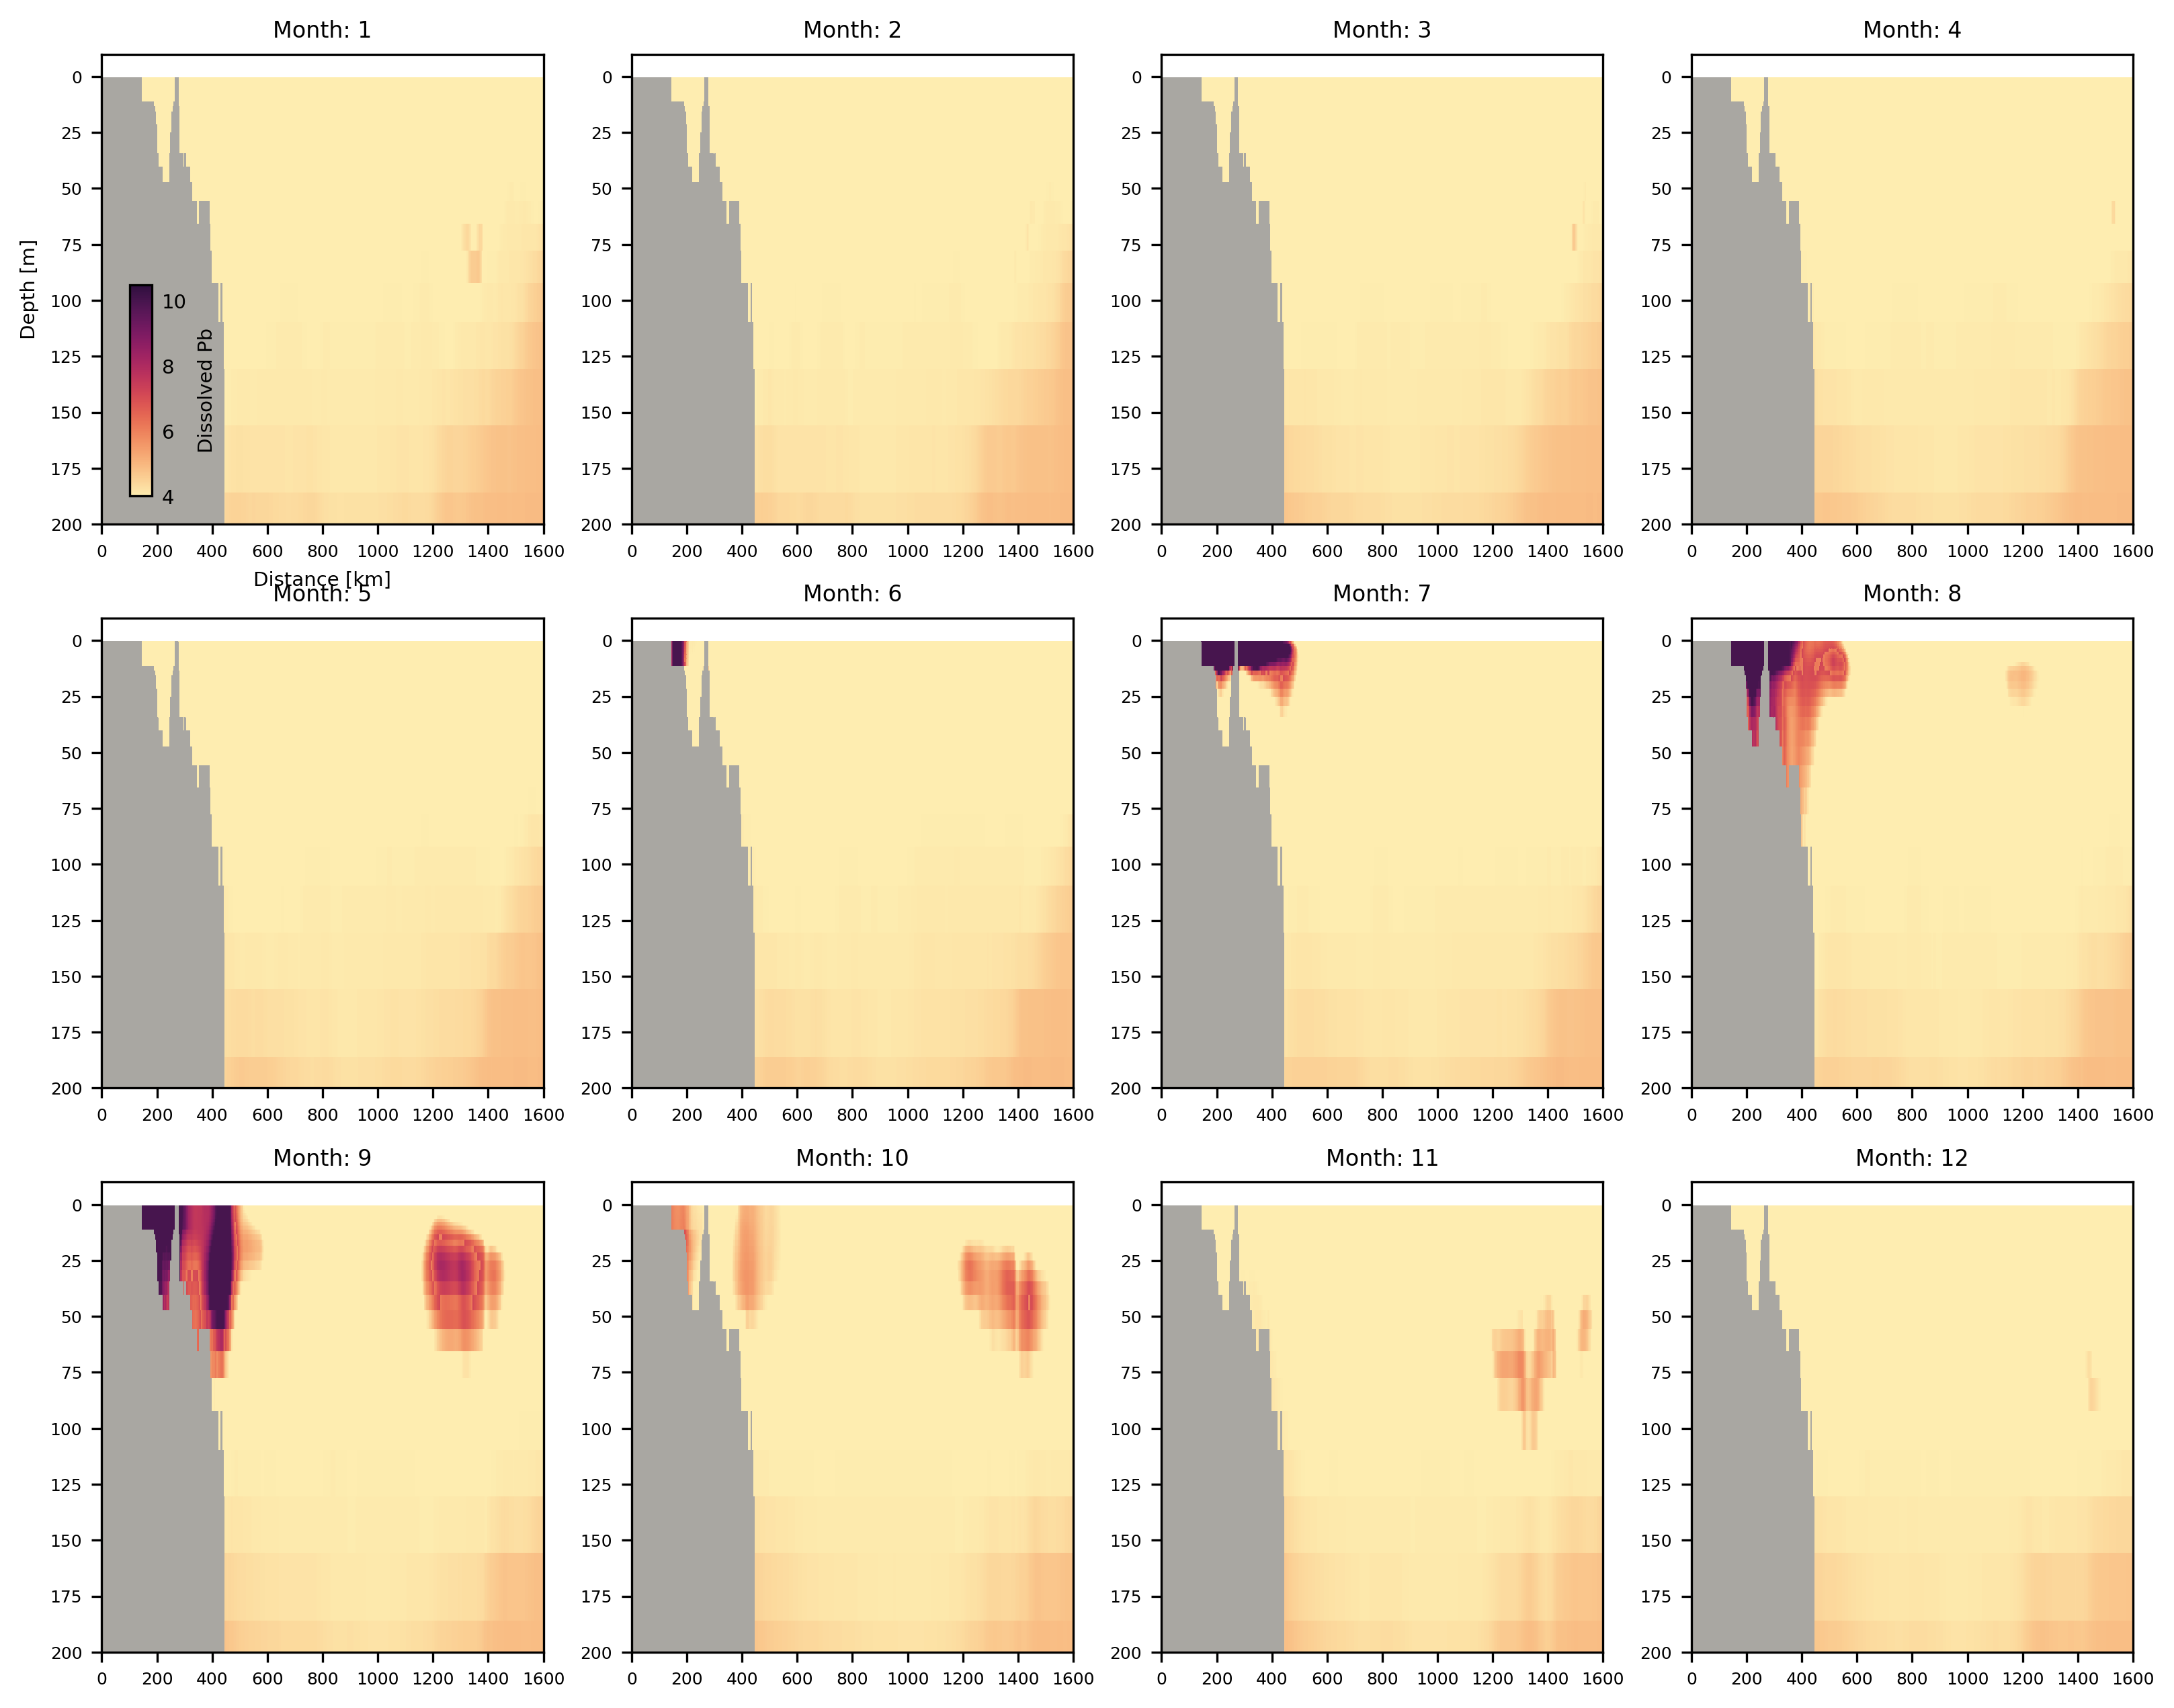

In [73]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=300)

axes = ax.ravel()

for month in range(0,12):
   
    if month > 0:
        plot_wCB_transect(axes[month], dPb_N_monthly[month,:,:,:], vrange=(4,10.5), label='Dissolved Pb', 
                          cmap=cmocean.cm.matter, labelling=False)
    else:
        plot_wCB_transect(axes[month], dPb_N_monthly[month,:,:,:], vrange=(4,10.5), label='Dissolved Pb', 
                          cmap=cmocean.cm.matter, labelling=True)
        
    axes[month].set_title(f'Month: {month+1}', fontsize=8)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/wCB_boundary_conditions_2015.jpg', dpi=300, bbox_inches='tight')